In [1]:
import pandas as pd
import numpy as np 
import ast 
import io
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
movies_df = pd.read_csv("/content/drive/MyDrive/CSE 475 Project/movies.csv")
ratings = pd.read_csv("/content/drive/MyDrive/CSE 475 Project/ratings.csv")
movies = pd.read_csv("/content/drive/MyDrive/CSE 475 Project/tmdb_5000_movies.csv",index_col=False, encoding='iso-8859-1', nrows=1000)
credits = pd.read_csv("/content/drive/MyDrive/CSE 475 Project/tmdb_5000_credits.csv",index_col=False, encoding='iso-8859-1', nrows=1000)

**Movie recommender applying KNN**

In [4]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
ratings.shape

(100836, 4)

In [7]:
movies_users=ratings.pivot(index='movieId',columns='userId', values='rating').fillna(0)
movies_users.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Using sparse matrix

mat_movies = csr_matrix(movies_users.values)
mat_movies

<9724x610 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in Compressed Sparse Row format>

In [9]:
model = NearestNeighbors(metric= 'cosine',algorithm='brute',n_neighbors=20)
model.fit(mat_movies)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [10]:
!pip install fuzzywuzzy

from fuzzywuzzy import fuzz
from fuzzywuzzy import process

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [11]:
def recommender(movie_name, data,n):
  idx = process.extractOne(movie_name, movies['title'])[2]
  print('Movie selected: ', movies['title'][idx], 'index: ',idx)
  print('Searching for recommondation..........')
  distance, indices = model.kneighbors(data[idx], n_neighbors=n)
  for i in indices :
    print(movies_df['title'][i].where(i!=idx))

In [12]:
#Here is the recommendationg applying KNN aproach

recommender('Iron Man', mat_movies, 10)

Movie selected:  Iron Man index:  68
Searching for recommondation..........
68                                                   NaN
555    Bloodsport 2 (a.k.a. Bloodsport II: The Next K...
59             Lawnmower Man 2: Beyond Cyberspace (1996)
669                                     First Kid (1996)
574                                    Quest, The (1996)
149                             Lord of Illusions (1995)
595                                     Barb Wire (1996)
71                                     Juror, The (1996)
162                           Scarlet Letter, The (1995)
88                                      City Hall (1996)
Name: title, dtype: object


**Applying Demographic Filtering System Based on Weight Rating**

In [13]:
movies.tail()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
995,60000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 18, ""na...",NaN,109491,"[{""id"": 393, ""name"": ""civil war""}, {""id"": 531,...",en,Beautiful Creatures,Ethan Wate just wants to get to know Lena Duch...,40.721373,"[{""name"": ""Alcon Entertainment"", ""id"": 1088}, ...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2013-02-13,60052138,124,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Dark secrets will come to light.,Beautiful Creatures,5.6,984
996,55000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 80, ""nam...",NaN,9275,"[{""id"": 417, ""name"": ""corruption""}, {""id"": 224...",en,Death to Smoochy,"Tells the story of Rainbow Randolph, the corru...",11.329727,"[{""name"": ""Senator Film Produktion"", ""id"": 191...","[{""iso_3166_1"": ""DE"", ""name"": ""Germany""}, {""is...",2002-03-28,0,109,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Get ready for an unexpected hit.,Death to Smoochy,5.9,132
997,50000000,"[{""id"": 35, ""name"": ""Comedy""}]",http://www.zoolander.com/,329833,"[{""id"": 6241, ""name"": ""stupidity""}, {""id"": 966...",en,Zoolander 2,Derek and Hansel are modelling again when an o...,37.253774,"[{""name"": ""Scott Rudin Productions"", ""id"": 258...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016-02-06,55969000,100,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Long time no Z,Zoolander 2,4.7,797
998,50000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 80, ""nam...",NaN,12634,"[{""id"": 612, ""name"": ""hotel""}, {""id"": 642, ""na...",en,The Big Bounce,A small-time con artist and a Hawaiian real es...,6.397388,"[{""name"": ""Shangri-La Entertainment"", ""id"": 22...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2004-01-30,6808550,88,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,It's all in who you trust,The Big Bounce,5.0,76
999,60000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",NaN,10416,"[{""id"": 3767, ""name"": ""noises""}, {""id"": 4862, ...",en,What Planet Are You From?,"A highly-evolved planet, whose denizens feel n...",2.275331,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2000-03-03,0,105,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"To save his planet, an alien must find a woman...",What Planet Are You From?,5.4,37


In [14]:
credits.tail()

,movie_id,title,cast,crew
995,109491,Beautiful Creatures,"[{""cast_id"": 12, ""character"": ""Ethan Wate"", ""c...","[{""credit_id"": ""55950f8c925141683b001aab"", ""de..."
996,9275,Death to Smoochy,"[{""cast_id"": 8, ""character"": ""Rainbow Randolph...","[{""credit_id"": ""52fe44e0c3a36847f80af3af"", ""de..."
997,329833,Zoolander 2,"[{""cast_id"": 0, ""character"": ""Derek Zoolander""...","[{""credit_id"": ""54ff0d5e9251410e56001a13"", ""de..."
998,12634,The Big Bounce,"[{""cast_id"": 1, ""character"": ""Jack Ryan"", ""cre...","[{""credit_id"": ""52fe450c9251416c75049f8b"", ""de..."
999,10416,What Planet Are You From?,"[{""cast_id"": 1, ""character"": ""Harold Anderson""...","[{""credit_id"": ""52fe436b9251416c7500f8df"", ""de..."


For Demographical Filtering-
we need a metric to score or rate movie
Calculate the score for every movie
Sort the scores and recommend the best rated movie to the users.

In [15]:
credits.columns = ['id','title','cast','crew']
movies= movies.merge(credits,on='id')

In [16]:
movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bonds past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [17]:
#c is mean votes
C= movies['vote_average'].mean()
C

6.218100000000001

In [18]:
#m is minimum votes

m= movies['vote_count'].quantile(0.8)
m

2676.000000000001

In [19]:
q_movies = movies.copy().loc[movies['vote_count'] >= m]
q_movies.shape

(200, 23)

We see that there are 200 movies which qualify to be in this list. Now, we need to calculate our metric for each qualified movie. To do this, we will define a function, weighted_rating() and define a new feature score, of which we'll calculate the value by applying this function to our DataFrame of qualified movies:

In [20]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [21]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [22]:
q_movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew,score
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",7.018488
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",6.645713
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bonds past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",6.269313
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",7.286134
5,258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",http://www.sonypictures.com/movies/spider-man3/,559,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,Spider-Man 3,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de...",6.036154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,60000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 16, ""...",http://www.shrek.com/,808,"[{""id"": 2343, ""name"": ""magic""}, {""id"": 2434, ""...",en,Shrek,It ain't easy bein' green -- especially if you...,67.298732,"[{""name"": ""DreamWorks SKG"", ""id"": 27}, {""name""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The greatest fairy tale never told.,Shrek,7.3,4056,Shrek,"[{""cast_id"": 24, ""character"": ""Shrek (voice)"",...","[{""credit_id"": ""52fe4279c3a36847f802182b"", ""de...",6.869940
903,50000000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 14, ""nam...",http://www.tedisreal.com/,72105,"[{""id"": 6054, ""name"": ""friendship""}, {""id"": 96...",en,Ted,"John Bennett, a man whose childhood wish of br...",68.876910,"[{""na

In [23]:
q_movies= q_movies .drop('title_y', axis=1)

In [24]:
q_movies= q_movies.rename(columns={'title_x': 'title'})


In [25]:
q_movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,score
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",7.018488
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",6.645713
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bonds past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",6.269313
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",7.286134
5,258000000,"[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...",http://www.sonypictures.com/movies/spider-man3/,559,"[{""id"": 851, ""name"": ""dual identity""}, {""id"": ...",en,Spider-Man 3,The seemingly invincible Spider-Man goes up ag...,115.699814,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,139,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,The battle within.,Spider-Man 3,5.9,3576,"[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de...",6.036154


In [26]:
#Sort movies based on score calculated above
q_movies = q_movies.sort_values('score', ascending=False)

#Print the top 10 movies
q_movies[['title','vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
662,Fight Club,9413,8.3,7.839154
65,The Dark Knight,12002,8.2,7.838673
96,Inception,13752,8.1,7.793452
95,Interstellar,10867,8.1,7.728150
809,Forrest Gump,7927,8.2,7.699805
329,The Lord of the Rings: The Return of the King,8064,8.1,7.631102
262,The Lord of the Rings: The Fellowship of the Ring,8705,8.0,7.581024
94,Guardians of the Galaxy,9742,7.9,7.537561
330,The Lord of the Rings: The Two Towers,7487,8.0,7.530811
634,The Matrix,8907,7.9,7.511434


Text(0.5, 1.0, 'Popular Movies')

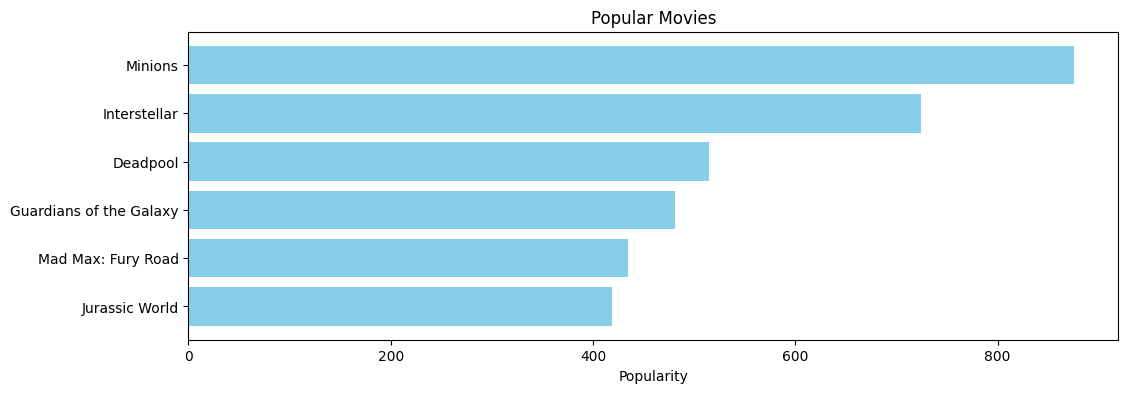

In [27]:
popular= q_movies.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(popular['title'].head(6),popular['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")


**Content Based Filtering**

In [28]:
movies= movies .drop('title_y', axis=1)
movies= movies.rename(columns={'title_x': 'title'})
movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,2787965087,162,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,961000000,169,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bonds past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,880674609,148,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,1084939099,165,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,284139100,132,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [29]:
movies['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bonds past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

In [30]:

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
q_movies['overview'] = movies['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(1000, 8849)

In [31]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [32]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

**Showing similar movies based on title**

In [33]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies['title'].iloc[movie_indices]

In [34]:
#get_recommendations
get_recommendations(input("Enter movie name: "))

Enter movie name: The Dark Knight


3                   The Dark Knight Rises
428                        Batman Returns
299                        Batman Forever
119                         Batman Begins
9      Batman v Superman: Dawn of Justice
879                   Law Abiding Citizen
210                        Batman & Robin
506                       Despicable Me 2
205    Sherlock Holmes: A Game of Shadows
606                              Blackhat
Name: title, dtype: object

In [35]:
get_recommendations(input("Enter movie name: "))

Enter movie name: Iron Man


79                      Iron Man 2
31                      Iron Man 3
7          Avengers: Age of Ultron
538                        Hostage
119                  Batman Begins
570                         Ransom
660                  Proof of Life
80     Snow White and the Huntsman
0                           Avatar
234                     The Croods
Name: title, dtype: object

**Showing similar movies based on genres, cast, crew**

In [36]:
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

In [37]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [38]:
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        if len(names) > 3:
            names = names[:3]
        return names
    return []

In [39]:
movies['director'] = movies['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [40]:
movies[['title', 'cast', 'director', 'keywords', 'genres']].tail(3)[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
997,Zoolander 2,"[Ben Stiller, Owen Wilson, Will Ferrell]",Ben Stiller,"[stupidity, sequel, fashion]",[Comedy]
998,The Big Bounce,"[Owen Wilson, Morgan Freeman, Gary Sinise]",George Armitage,"[hotel, robbery, based on novel]","[Comedy, Crime]"
999,What Planet Are You From?,"[Garry Shandling, Annette Bening, John Goodman]",Mike Nichols,"[noises, alien life-form, erection]","[Comedy, Drama, Romance]"


In [41]:
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

creating our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [42]:
features = ['cast', 'keywords', 'director', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(clean_data)

In [43]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movies['soup'] = movies.apply(create_soup, axis=1)

In [44]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies['soup'])

In [45]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [46]:
# Reset index of our main DataFrame and construct reverse mapping as before
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['title'])

In [47]:
#We can now reuse our get_recommendations() function by passing in the new cosine_sim2 matrix as your second argument.
get_recommendations('Forrest Gump', cosine_sim2)

323        Sex and the City 2
384                 Cast Away
638           You've Got Mail
438    Something's Gotta Give
440          Four Christmases
521              The Terminal
524      Charlie Wilson's War
690            The Green Mile
710            The Family Man
815                     Hitch
Name: title, dtype: object

In [48]:
get_recommendations('Shutter Island', cosine_sim2)

351          The Departed
622          Body of Lies
693             Gone Girl
250           The Aviator
776         Winter's Tale
49       The Great Gatsby
128       Angels & Demons
774       The Last Castle
872    All the King's Men
25                Titanic
Name: title, dtype: object

**Collaborative Filtering**

**User-based similarity Pearson’s correlation**

In [49]:
df = ratings.merge(movies_df, left_on='movieId', right_on='movieId', how='left')
df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [50]:
from sklearn.metrics.pairwise import cosine_similarity

In [51]:
del df['timestamp']

In [52]:
user_movie_matrix = pd.pivot_table(df, values = 'rating', index='movieId', columns = 'userId')
user_movie_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
user_movie_matrix = user_movie_matrix.fillna(0)
user_movie_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
#user-based collaborative filtering

user_user_matrix = user_movie_matrix.corr(method='pearson')
user_user_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.019400,0.053056,0.176920,0.120866,0.104418,0.143793,0.128547,0.055268,-0.000298,...,0.066256,0.149942,0.186978,0.056530,0.134412,0.121981,0.254200,0.262241,0.085434,0.098719
2,0.019400,1.000000,-0.002594,-0.003804,0.013183,0.016257,0.021567,0.023750,-0.003448,0.061880,...,0.198549,0.010888,-0.004030,-0.005345,-0.007919,0.011299,0.005813,0.032730,0.024373,0.089329
3,0.053056,-0.002594,1.000000,-0.004556,0.001887,-0.004577,-0.005634,0.001703,-0.003111,-0.005501,...,0.000150,-0.000585,0.011211,-0.004822,0.003678,-0.003246,0.012885,0.008096,-0.002963,0.015962
4,0.176920,-0.003804,-0.004556,1.000000,0.121018,0.065719,0.100602,0.054235,0.002417,0.015615,...,0.072848,0.114287,0.281866,0.039699,0.065493,0.164831,0.115118,0.116861,0.023930,0.062523
5,0.120866,0.013183,0.001887,0.121018,1.000000,0.294138,0.101725,0.426576,-0.004185,0.023471,...,0.061912,0.414931,0.095394,0.254117,0.141077,0.090158,0.145764,0.122607,0.258289,0.040372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.121981,0.011299,-0.003246,0.164831,0.090158,0.047506,0.172499,0.081913,0.057989,0.054877,...,0.153892,0.084208,0.224637,0.035251,0.106752,1.000000,0.115999,0.188354,0.052385,0.093851
607,0.254200,0.005813,0.012885,0.115118,0.145764,0.142169,0.173293,0.178133,0.003257,-0.004809,...,0.080034,0.187588,0.173025,0.126267,0.101138,0.115999,1.000000,0.258245,0.142533,0.098518
608,0.262241,0.032730,0.008096,0.116861,0.122607,0.137954,0.305439,0.175912,0.086229,0.048373,...,0.136316,0.174069,0.164479,0.133734,0.144896,0.188354,0.258245,1.000000,0.109563,0.248944


As we can see from the above matrix, higher positive values means more similar and negative values mean not similar. Eg: Similarty of user 1 and user 2 is 0.019400 but similarity of user1 and user3 is 0.053056, which means User1 is more similar to User3.

In [55]:
#Extarcing top 10 similar users for User1 by sorting them in descending order
# based on their similarties

user_user_matrix.loc[1].sort_values(ascending=False).head(10)

userId
1      1.000000
266    0.344983
313    0.333875
368    0.324041
57     0.323948
39     0.320120
452    0.313150
91     0.311346
469    0.309089
45     0.307568
Name: 1, dtype: float64

In [56]:
#Extarcing top 10 similar users for User1 by sorting

user_user_matrix.loc[2].sort_values(ascending=False).head(10)

userId
2      1.000000
366    0.297982
417    0.277366
378    0.273342
550    0.252051
189    0.240668
528    0.238262
461    0.237457
495    0.235147
435    0.231771
Name: 2, dtype: float64

In [57]:
#Converting the above data into a DF and removing the user2 itself 
#(A user will be always similar to iteself with a rating of 1)

df_2 = pd.DataFrame(user_user_matrix.loc[2].sort_values(ascending=False).head(10))
df_2 = df_2.reset_index()
df_2.columns = ['userId', 'similarity']

In [58]:
df_2 = df_2.drop((df_2[df_2['userId'] ==2]).index)
df_2

,userId,similarity
1,366,0.297982
2,417,0.277366
3,378,0.273342
4,550,0.252051
5,189,0.240668
6,528,0.238262
7,461,0.237457
8,495,0.235147
9,435,0.231771


In [59]:
#Now we are creating a new DF which has all the similar users and their rated movies

final_df = df_2.merge(df, left_on='userId', right_on='userId', how='left')
final_df

,userId,similarity,movieId,rating,title,genres
0,366,0.297982,110,4.0,Braveheart (1995),Action|Drama|War
1,366,0.297982,589,4.0,Terminator 2: Judgment Day (1991),Action|Sci-Fi
2,366,0.297982,1036,4.0,Die Hard (1988),Action|Crime|Thriller
3,366,0.297982,1089,5.0,Reservoir Dogs (1992),Crime|Mystery|Thriller
4,366,0.297982,2028,4.0,Saving Private Ryan (1998),Action|Drama|War
...,...,...,...,...,...,...
596,435,0.231771,68954,4.0,Up (2009),Adventure|Animation|Children|Drama
597,435,0.231771,74458,4.5,Shutter Island (2010),Drama|Mystery|Thriller
598,435,0.231771,79132,4.5,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
599,435,0.231771,80463,4.5,"Social Network, The (2010)",Drama


In [60]:
final_df['score'] = final_df['similarity']*final_df['rating']
final_df

,userId,similarity,movieId,rating,title,genres,score
0,366,0.297982,110,4.0,Braveheart (1995),Action|Drama|War,1.191930
1,366,0.297982,589,4.0,Terminator 2: Judgment Day (1991),Action|Sci-Fi,1.191930
2,366,0.297982,1036,4.0,Die Hard (1988),Action|Crime|Thriller,1.191930
3,366,0.297982,1089,5.0,Reservoir Dogs (1992),Crime|Mystery|Thriller,1.489912
4,366,0.297982,2028,4.0,Saving Private Ryan (1998),Action|Drama|War,1.191930
...,...,...,...,...,...,...,...
596,435,0.231771,68954,4.0,Up (2009),Adventure|Animation|Children|Drama,0.927083
597,435,0.231771,74458,4.5,Shutter Island (2010),Drama|Mystery|Thriller,1.042968
598,435,0.231771,79132,4.5,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX,1.042968
599,435,0.231771,80463,4.5,"Social Network, The (2010)",Drama,1.042968


In [61]:
#Creating a df for all the movies which are already watched by our target user2
watched_df = df[df['userId'] == 2]
watched_df

,userId,movieId,rating,title,genres
232,2,318,3.0,"Shawshank Redemption, The (1994)",Crime|Drama
233,2,333,4.0,Tommy Boy (1995),Comedy
234,2,1704,4.5,Good Will Hunting (1997),Drama|Romance
235,2,3578,4.0,Gladiator (2000),Action|Adventure|Drama
236,2,6874,4.0,Kill Bill: Vol. 1 (2003),Action|Crime|Thriller
237,2,8798,3.5,Collateral (2004),Action|Crime|Drama|Thriller
238,2,46970,4.0,Talladega Nights: The Ballad of Ricky Bobby (2...,Action|Comedy
239,2,48516,4.0,"Departed, The (2006)",Crime|Drama|Thriller
240,2,58559,4.5,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
241,2,60756,5.0,Step Brothers (2008),Comedy


In [62]:
cond = final_df['movieId'].isin(watched_df['movieId'])
final_df.drop(final_df[cond].index, inplace = True) 

In [63]:
from pandas.io.parsers.readers import read_fwf
recommended_df = final_df.sort_values(by = 'score', ascending = False)['title'].head(10)
recommended_df = recommended_df.reset_index()
del recommended_df['index']

In [64]:
recommended_df

,title
0,Reservoir Dogs (1992)
1,"Truman Show, The (1998)"
2,"Matrix, The (1999)"
3,Trainspotting (1996)
4,"Godfather, The (1972)"
5,The Butterfly Effect (2004)
6,"Clockwork Orange, A (1971)"
7,"Godfather: Part II, The (1974)"
8,"Shining, The (1980)"
9,"Lord of the Rings: The Return of the King, The..."


**Finding root mean square error and mean absolute error by usiing KnnBasic with cross validation**

In [68]:
#coverting data in to surprise dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [69]:
model_user_based = KNNBasic(sim_options ={'name':'cosine','user_base':True},verbose=False)
results = cross_validate(model_user_based, data, measures=['rmse', 'mae'], cv=5, verbose=False)

In [70]:
print('Average RMSE for Test Set using {} is '.format(model_user_based.__class__.__name__),results['test_rmse'].mean())
print('Average MAE for Test Set using {} is '.format(model_user_based.__class__.__name__),results['test_mae'].mean())

Average RMSE for Test Set using KNNBasic is  0.9722759697726664
Average MAE for Test Set using KNNBasic is  0.7489339719218819


### **Item-based similarity Pearson’s correlation**

In [71]:
df = ratings.merge(movies_df, left_on='movieId', right_on='movieId', how='left')
df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [72]:
del df['timestamp']

In [73]:
movie_user_matrix = pd.pivot_table(df, values='rating', index='userId', columns='movieId')
movie_user_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
movie_user_matrix = movie_user_matrix.fillna(0)
movie_user_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
#Item-based collaborative filtering
item_item_matrix = movie_user_matrix.corr(method='pearson')
item_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.231327,0.173213,-0.028917,0.192474,0.192686,0.143743,0.085477,0.177245,0.183382,...,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906
2,0.231327,1.000000,0.191945,0.071269,0.200526,0.158341,0.127569,0.141540,-0.021045,0.285086,...,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291
3,0.173213,0.191945,1.000000,0.067143,0.370171,0.196442,0.351513,0.296897,0.275812,0.136916,...,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729
4,-0.028917,0.071269,0.067143,1.000000,0.167910,0.053755,0.258075,0.148726,-0.016025,0.056000,...,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138
5,0.192474,0.200526,0.370171,0.167910,1.000000,0.215503,0.429890,0.265777,0.308085,0.110833,...,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,-0.028906,-0.018291,-0.011729,-0.004138,-0.011456,-0.017712,-0.012033,-0.004383,-0.006359,-0.020524,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.001642
193583,-0.028906,-0.018291,-0.011729,-0.004138,-0.011456,-0.017712,-0.012033,-0.004383,-0.006359,-0.020524,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.001642
193585,-0.028906,-0.018291,-0.011729,-0.004138,-0.011456,-0.017712,-0.012033,-0.004383,-0.006359,-0.020524,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.001642


As we can see from the above matrix, higher +ve values means more similar and -ve values mean not similar. Eg: Similarty of movie1 and movie2 is 0.231327 but similarity of movie1 and movie3 is 0.173213, which means User1 is more similar to User2.

In [76]:
#Extarcing top 10 similar users for movieId 3 by sorting them in descending order based on their similarties
item_item_matrix.loc[3].sort_values(ascending=False).head(10)

movieId
3       1.000000
3450    0.415447
762     0.408148
788     0.388505
542     0.378602
65      0.371938
5       0.370171
736     0.365382
79      0.362135
419     0.355557
Name: 3, dtype: float64

In [77]:
#Converting the above data into a DF and removing the movieId 2 itself 
 #(A movie will be always similar to iteself with a rating of 1)
df_2 = pd.DataFrame(item_item_matrix.loc[3].sort_values(ascending=False).head(10))
df_2 = df_2.reset_index()
df_2.columns = ['movieId', 'similarity']

In [78]:
df_2 = df_2.drop((df_2[df_2['movieId'] == '3']).index)
df_2

,movieId,similarity
0,3,1.000000
1,3450,0.415447
2,762,0.408148
3,788,0.388505
4,542,0.378602
5,65,0.371938
6,5,0.370171
7,736,0.365382
8,79,0.362135
9,419,0.355557


In [79]:
#Now we are creating a new DF which has all the similar movies and their rated movies
final_df = df_2.merge(df, left_on='movieId', right_on='movieId', how='left')
final_df

,movieId,similarity,userId,rating,title,genres
0,3,1.000000,1,4.0,Grumpier Old Men (1995),Comedy|Romance
1,3,1.000000,6,5.0,Grumpier Old Men (1995),Comedy|Romance
2,3,1.000000,19,3.0,Grumpier Old Men (1995),Comedy|Romance
3,3,1.000000,32,3.0,Grumpier Old Men (1995),Comedy|Romance
4,3,1.000000,42,4.0,Grumpier Old Men (1995),Comedy|Romance
...,...,...,...,...,...,...
453,419,0.355557,555,5.0,"Beverly Hillbillies, The (1993)",Comedy
454,419,0.355557,590,2.5,"Beverly Hillbillies, The (1993)",Comedy
455,419,0.355557,592,3.0,"Beverly Hillbillies, The (1993)",Comedy
456,419,0.355557,599,0.5,"Beverly Hillbillies, The (1993)",Comedy


In [80]:
final_df['score'] = final_df['similarity'] * final_df['rating']
final_df

,movieId,similarity,userId,rating,title,genres,score
0,3,1.000000,1,4.0,Grumpier Old Men (1995),Comedy|Romance,4.000000
1,3,1.000000,6,5.0,Grumpier Old Men (1995),Comedy|Romance,5.000000
2,3,1.000000,19,3.0,Grumpier Old Men (1995),Comedy|Romance,3.000000
3,3,1.000000,32,3.0,Grumpier Old Men (1995),Comedy|Romance,3.000000
4,3,1.000000,42,4.0,Grumpier Old Men (1995),Comedy|Romance,4.000000
...,...,...,...,...,...,...,...
453,419,0.355557,555,5.0,"Beverly Hillbillies, The (1993)",Comedy,1.777787
454,419,0.355557,590,2.5,"Beverly Hillbillies, The (1993)",Comedy,0.888893
455,419,0.355557,592,3.0,"Beverly Hillbillies, The (1993)",Comedy,1.066672
456,419,0.355557,599,0.5,"Beverly Hillbillies, The (1993)",Comedy,0.177779


In [81]:
#Creating a df for all the movies which are already watched by our target user3

watched_df = df[df['userId'] == 3]
watched_df

,userId,movieId,rating,title,genres
261,3,31,0.5,Dangerous Minds (1995),Drama
262,3,527,0.5,Schindler's List (1993),Drama|War
263,3,647,0.5,Courage Under Fire (1996),Action|Crime|Drama|War
264,3,688,0.5,Operation Dumbo Drop (1995),Action|Adventure|Comedy|War
265,3,720,0.5,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy
266,3,849,5.0,Escape from L.A. (1996),Action|Adventure|Sci-Fi|Thriller
267,3,914,0.5,My Fair Lady (1964),Comedy|Drama|Musical|Romance
268,3,1093,0.5,"Doors, The (1991)",Drama
269,3,1124,0.5,On Golden Pond (1981),Drama
270,3,1263,0.5,"Deer Hunter, The (1978)",Drama|War


In [82]:
from pandas.io.parsers.readers import read_fwf
cond = final_df['movieId'].isin(watched_df['movieId'])
final_df.drop(final_df[cond].index, inplace = True) 

In [83]:
recommended_df = final_df.sort_values(by = 'score', ascending = False)['title'].tail(10)
recommended_df = recommended_df.reset_index()
del recommended_df['index']

In [84]:
recommended_df

,title
0,Striptease (1996)
1,Striptease (1996)
2,"Nutty Professor, The (1996)"
3,"Nutty Professor, The (1996)"
4,"Nutty Professor, The (1996)"
5,"Nutty Professor, The (1996)"
6,Son in Law (1993)
7,Father of the Bride Part II (1995)
8,"Beverly Hillbillies, The (1993)"
9,"Beverly Hillbillies, The (1993)"


**Finding mean square error and mean absolute error by usiing KnnBasic with cross validation**

In [85]:
#coverting data in to surprise dataset
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [86]:
model_user_based = KNNBasic(sim_options ={'name':'cosine','user_base':False},verbose=False)
result_item = cross_validate(model_user_based, data, measures=['rmse', 'mae'], cv=10, verbose=False)

In [87]:

print('Average RMSE for Test Set using {} is '.format(model_user_based.__class__.__name__),result_item['test_rmse'].mean())
print('Average MAE for Test Set using {} is '.format(model_user_based.__class__.__name__),result_item['test_mae'].mean())

Average RMSE for Test Set using KNNBasic is  0.9683089030105376
Average MAE for Test Set using KNNBasic is  0.7453626212062427


**Evaluate by Precision and Recall**

In [88]:
from collections import defaultdict

In [102]:
#function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [103]:
#A basic cross-validation iterator.
kf = KFold(n_splits=5)

In [104]:
# Make list of models
models = [KNNBasic(sim_options={'name': 'cosine', 'user_based': True}, verbose=False),
          KNNBasic(sim_options={'name': 'cosine', 'user_based': False}, verbose=False)]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k, model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))

        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

NameError: ignored

**Single Value Decomposition(SVD)**

In [66]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095452 sha256=da35d85eb694dfcba03bc4dadf8a71a32515e423fe4528e971d0102dd83a4c3f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [67]:
from surprise import Reader, Dataset, SVD 
from surprise.model_selection import cross_validate
from surprise import KNNBasic
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
reader = Reader()
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [93]:
#Note that in this dataset movies are rated on a scale of 5 unlike the earlier one.
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
# Assuming you want to use the SVD algorithm
algo = SVD()

# Split the data into folds for cross-validation
kf = KFold(n_splits=5)
for trainset, testset in kf.split(data):
    # Train the algorithm on the trainset
    algo.fit(trainset)

    # Test the algorithm on the testset
    predictions = algo.test(testset)

In [94]:
svd = SVD()
# Perform cross-validation
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Print the average results
print('Average RMSE:', results['test_rmse'].mean())
print('Average MAE:', results['test_mae'].mean())

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8651  0.8760  0.8771  0.8750  0.8765  0.8739  0.0045  
MAE (testset)     0.6630  0.6701  0.6749  0.6729  0.6757  0.6713  0.0046  
Fit time          1.39    2.11    1.68    1.39    1.40    1.59    0.28    
Test time         0.42    0.22    0.30    0.13    0.13    0.24    0.11    
Average RMSE: 0.8739340980525355
Average MAE: 0.6713206919159859


In [95]:
# train on our dataset and arrive at predictions.
trainset = data.build_full_trainset()
svd.fit(trainset)

In [96]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
227,1,3744,4.0,964980694
228,1,3793,5.0,964981855
229,1,3809,4.0,964981220
230,1,4006,4.0,964982903


In [97]:
svd.predict(1, 302, 4)

Prediction(uid=1, iid=302, r_ui=4, est=4.0998721147804735, details={'was_impossible': False})

For movie with ID 302, we get an estimated prediction of4.099872. One startling feature of this recommender system is that it doesn't care what the movie is (or what it contains). It works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

**Hybrid Recommender**

In [98]:
def collaborative_filtering_recommendations(user_id):
    # Create a Surprise Reader object
    reader = Reader(rating_scale=(1, 5))

    # Load the ratings data into Surprise Dataset format
    ratings_data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

    # Build the training set
    trainset = ratings_data.build_full_trainset()

    # Create and train the SVD algorithm
    svd = SVD()
    svd.fit(trainset)

    # Generate recommendations for the given user
    user_recommendations = []
    for movie_id in movies_df['movieId'].unique():
        predicted_rating = svd.predict(user_id, movie_id).est
        user_recommendations.append((movie_id, predicted_rating))

    # Sort recommendations by predicted rating (in descending order)
    user_recommendations.sort(key=lambda x: x[1], reverse=True)

    # Get movie titles for the recommendations
    movie_titles = movies_df[movies_df['movieId'].isin([rec[0] for rec in user_recommendations])]
    recommendations_with_titles = [(rec[0], rec[1], movie_titles[movie_titles['movieId'] == rec[0]]['title'].values[0]) for rec in user_recommendations]

    return recommendations_with_titles

# Example usage
user_id = 1
recommendations = collaborative_filtering_recommendations(user_id)
for rec in recommendations:
    print(f"MovieID: {rec[0]}, Rating: {rec[1]}, Title: {rec[2]}")


Streaming output truncated to the last 5000 lines.
MovieID: 184257, Rating: 4.23978847991097, Title: Making a Murderer (2015)
MovieID: 159403, Rating: 4.239761864696584, Title: Neo Tokyo (1987)
MovieID: 71160, Rating: 4.239680808051325, Title: Hunt For Gollum, The (2009)
MovieID: 3568, Rating: 4.239624338211168, Title: Smiling Fish and Goat on Fire (1999)
MovieID: 93610, Rating: 4.239601066041075, Title: Space Battleship Yamato (2010)
MovieID: 1746, Rating: 4.239600569597148, Title: Senseless (1998)
MovieID: 54372, Rating: 4.239597288919018, Title: Tell No One (Ne le dis à personne) (2006)
MovieID: 6660, Rating: 4.2394917717747385, Title: Red Shoes, The (1948)
MovieID: 2990, Rating: 4.239441610339219, Title: Licence to Kill (1989)
MovieID: 74696, Rating: 4.2393816837276415, Title: Last Train Home (2009)
MovieID: 157369, Rating: 4.239335989086723, Title: Bakuman (2015)
MovieID: 63436, Rating: 4.239233960197326, Title: Saw V (2008)
MovieID: 89804, Rating: 4.239093443511016, Title: Ides o